In [71]:
import pyodbc
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Clustering 1-2-23.csv', delimiter= ";")
df = df[(df["Letra cluster"] == "A") | (df["Letra cluster"] == "B")]
df_10_ag = df[df["Distrito-Nombretipozona"] == '10-Artes graficas']

In [3]:
df_10_ag = df_10_ag.sort_values(by=["Recency", "Frequency", "Monetary"], ascending= False, )
df_10_ag

,Codigo distrito,Nombre tipo zona,Nit cliente-sucursal,Recency,Monetary,Frequency,Distrito-Nombretipozona,Cluster,Letra cluster
534,10,Artes graficas,830098200-1,24,3293858,24,10-Artes graficas,Cluster 3,A
535,10,Artes graficas,860530370-1,24,3079425,24,10-Artes graficas,Cluster 3,A
532,10,Artes graficas,800138131-1,24,2880098,24,10-Artes graficas,Cluster 3,A
526,10,Artes graficas,860000198-1,24,2394980,24,10-Artes graficas,Cluster 1,B
523,10,Artes graficas,800103903-1,24,2233923,24,10-Artes graficas,Cluster 1,B
527,10,Artes graficas,860521517-1,24,1693460,24,10-Artes graficas,Cluster 1,B
533,10,Artes graficas,800226417-1,24,4608290,23,10-Artes graficas,Cluster 3,A
529,10,Artes graficas,900085929-1,24,2165865,22,10-Artes graficas,Cluster 1,B
524,10,Artes graficas,800234331-1,24,1586684,22,10-Artes graficas,Cluster 1,B
525,10,Artes graficas,830068816-1,24,1576750,21,10-Artes graficas,Cluster 1,B


In [5]:
## Conexion al DWH
cnxn = pyodbc.connect(
    driver='{SQL Server}',
    server='192.168.100.58',
    uid='bilectura',
    pwd='D1sp@p3l3s')
cursor = cnxn.cursor()
#cnxn.close()

In [9]:
nit_cliente = "'800226417-1'"
nit_cliente = "'900085929-1'"
nit_cliente = "'900173543-1'"

In [28]:
fecha_final = "'2023-01-31'"

In [29]:
codigo_SQL = f"SELECT DATEFROMPARTS(VTAANO, VTAMES, 1) AS 'Fecha', SUM(VTAVLRVTA) AS 'Ventas' FROM V_VTA_VTAHEC WHERE CONCAT(CONCAT(VTANIT, '-'), VTASUC) = {nit_cliente} AND VTAFCH < {fecha_final} GROUP BY DATEFROMPARTS(VTAANO, VTAMES, 1)"

In [30]:
#Cargue de la data desde el ERP de Dispapeles y se guarda en df
cursor.execute(codigo_SQL)
rows = cursor.fetchall()
df_SQL = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])
df_SQL["Ventas"] = df_SQL["Ventas"].astype(int)

In [31]:
df_SQL.tail()

,Fecha,Ventas
56,2022-09-01,153077032
57,2022-10-01,218037069
58,2022-11-01,185362625
59,2022-12-01,357624848
60,2023-01-01,32073720


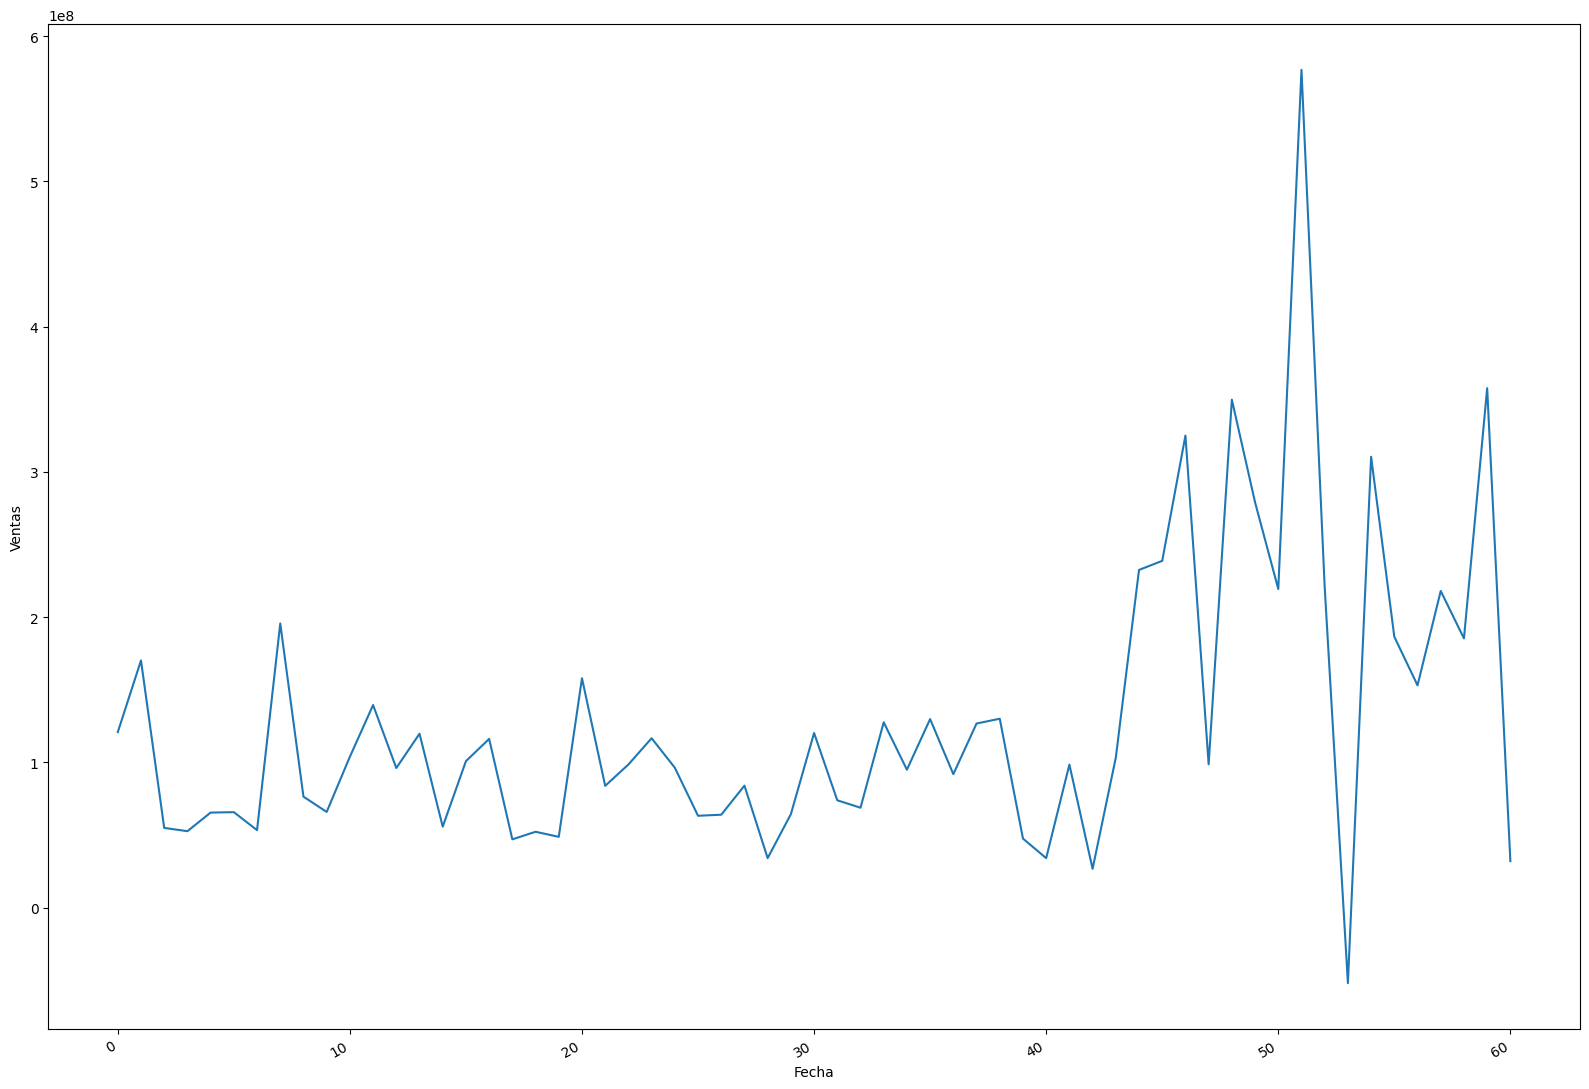

In [32]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(df_SQL['Ventas'])
ax.set_xlabel('Fecha')
ax.set_ylabel('Ventas')
fig.autofmt_xdate()
plt.tight_layout()

### Predict the next time step using the previous observation

In [33]:
df = df_SQL.copy()
df['y'] = df['Ventas'].shift(-1)

In [45]:
n_train = int(round(df.shape[0] * 0.7, 0))
n_train

43

In [53]:
train = df[:n_train]
test = df[n_train:]
test = test.drop(test.tail(1).index)

#### Decision tree

In [54]:
X_train = train['Ventas'].values.reshape(-1, 1)
y_train = train['y'].values.reshape(-1, 1)
X_test = test['Ventas'].values.reshape(-1, 1)

#Setup model
dt_reg = DecisionTreeRegressor(random_state= 42)

# Fit
dt_reg.fit(X= X_train, y= y_train)

# Predict
dt_pred = dt_reg.predict(X_test)
test['dt_pred'] = dt_pred

In [55]:
test

,Fecha,Ventas,y,dt_pred
43,2021-08-01,103303050,232498967.0,139524092.0
44,2021-09-01,232498967,238762912.0,76449181.0
45,2021-10-01,238762912,324989816.0,76449181.0
46,2021-11-01,324989816,98730448.0,76449181.0
47,2021-12-01,98730448,349724464.0,116661798.0
48,2022-01-01,349724464,279028516.0,76449181.0
49,2022-02-01,279028516,219390442.0,76449181.0
50,2022-03-01,219390442,576740396.0,76449181.0
51,2022-04-01,576740396,220617682.0,76449181.0
52,2022-05-01,220617682,-51902741.0,76449181.0


#### Gradient boosting

In [57]:
X_train = train['Ventas'].values.reshape(-1, 1)
y_train = train['y'].values.reshape(-1, 1)
X_test = test['Ventas'].values.reshape(-1, 1)

#Setup model
gbr = GradientBoostingRegressor(random_state= 42)

# Fit
gbr.fit(X= X_train, y= y_train.ravel())

# Predict
gbr_pred = gbr.predict(X_test)
test['gbr_pred'] = gbr_pred

In [58]:
test

,Fecha,Ventas,y,dt_pred,gbr_pred
43,2021-08-01,103303050,232498967.0,139524092.0,1.266428e+08
44,2021-09-01,232498967,238762912.0,76449181.0,7.589158e+07
45,2021-10-01,238762912,324989816.0,76449181.0,7.589158e+07
46,2021-11-01,324989816,98730448.0,76449181.0,7.589158e+07
47,2021-12-01,98730448,349724464.0,116661798.0,1.145409e+08
48,2022-01-01,349724464,279028516.0,76449181.0,7.589158e+07
49,2022-02-01,279028516,219390442.0,76449181.0,7.589158e+07
50,2022-03-01,219390442,576740396.0,76449181.0,7.589158e+07
51,2022-04-01,576740396,220617682.0,76449181.0,7.589158e+07
52,2022-05-01,220617682,-51902741.0,76449181.0,7.589158e+07


#### Evaluation MAPE

In [60]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

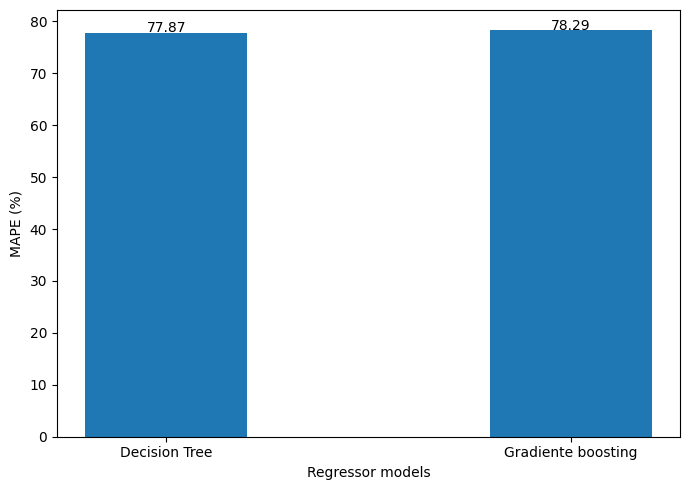

In [64]:
dt_mape = mape(test['y'], test['dt_pred'])
gbr_mape = mape(test['y'], test['gbr_pred'])

# Bar plot
fig, ax = plt.subplots(figsize=(7,5))

x = ["Decision Tree", "Gradiente boosting"]
y = [dt_mape, gbr_mape]

ax.bar(x, y, width= 0.4)
ax.set_xlabel("Regressor models")
ax.set_ylabel('MAPE (%)')

for index, value in enumerate(y):
    plt.text(x= index, y= value + 0.02, s= str(value), ha= 'center')

plt.tight_layout()

### Predict the next time step using a sequence of past observations

In [68]:
def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < window_length:
        df[f'x_{i}'] = df['Ventas'].shift(-i)
        i = i + 1
        
    if i == window_length:
        df['y'] = df['Ventas'].shift(-i)
        
    # Drop rows where there is a NaN
    df = df.dropna(axis=0)
        
    return df

In [69]:
new_df = window_input(5, df_SQL)

In [72]:
X = new_df[['Ventas', 'x_1', 'x_2', 'x_3', 'x_4']].values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

#### Baseline pred

In [73]:
baseline_pred = []

for row in X_test:
    baseline_pred.append(np.mean(row))

#### Decision Tree

In [74]:
dt_reg_5 = DecisionTreeRegressor(random_state=42)

dt_reg_5.fit(X_train, y_train)

dt_reg_5_pred = dt_reg_5.predict(X_test)

#### Gradient boosting

In [75]:
gbr_5 = GradientBoostingRegressor(random_state=42)

gbr_5.fit(X_train, y_train.ravel())

gbr_5_pred = gbr_5.predict(X_test)

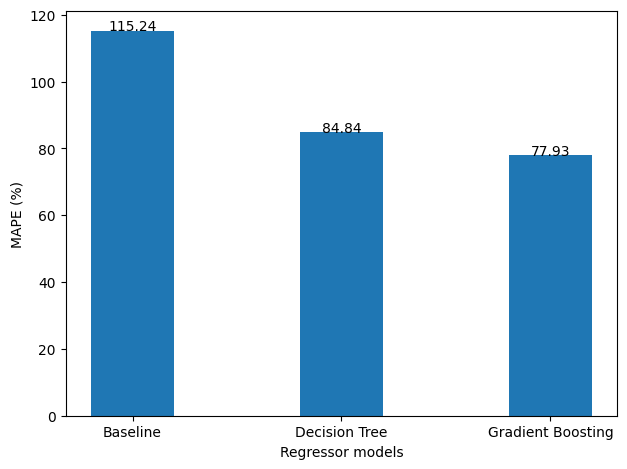

In [77]:
baseline_mape = mape(y_test, baseline_pred)
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_5_mape, gbr_5_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

### Predict a sequence of future time steps using a sequence of past observations

In [78]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['Ventas'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['Ventas'].shift(-output_length-j)
        j = j + 1
        
    df = df.dropna(axis=0)
    
    return df

In [80]:
seq_df = window_input_output(26, 26, df_SQL)

In [81]:
X_cols = [col for col in seq_df.columns if col.startswith('x')]

X_cols.insert(0, 'Ventas')

y_cols = [col for col in seq_df.columns if col.startswith('y')]
X_train = seq_df[X_cols][:-2].values
y_train = seq_df[y_cols][:-2].values

X_test = seq_df[X_cols][-2:].values
y_test = seq_df[y_cols][-2:].values

In [82]:
dt_seq = DecisionTreeRegressor(random_state=42)

dt_seq.fit(X_train, y_train)

dt_seq_preds = dt_seq.predict(X_test)

In [83]:
from sklearn.multioutput import RegressorChain

gbr_seq = GradientBoostingRegressor(random_state=42)

chained_gbr = RegressorChain(gbr_seq)

chained_gbr.fit(X_train, y_train)

gbr_seq_preds = chained_gbr.predict(X_test)

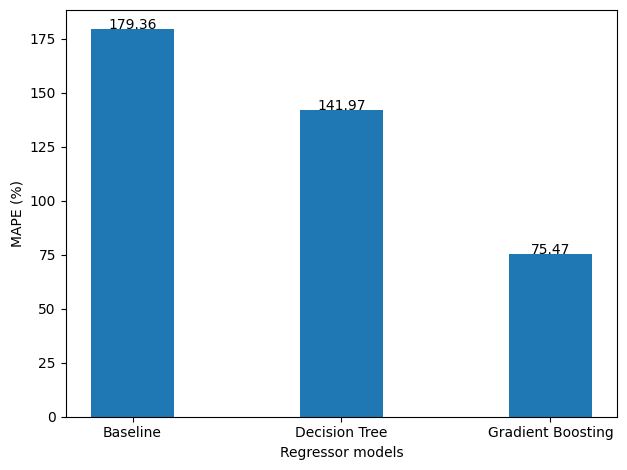

In [84]:
mape_dt_seq = mape(dt_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_gbr_seq = mape(gbr_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_baseline = mape(X_test.reshape(1, -1), y_test.reshape(1, -1))
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [mape_baseline, mape_dt_seq, mape_gbr_seq]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout()

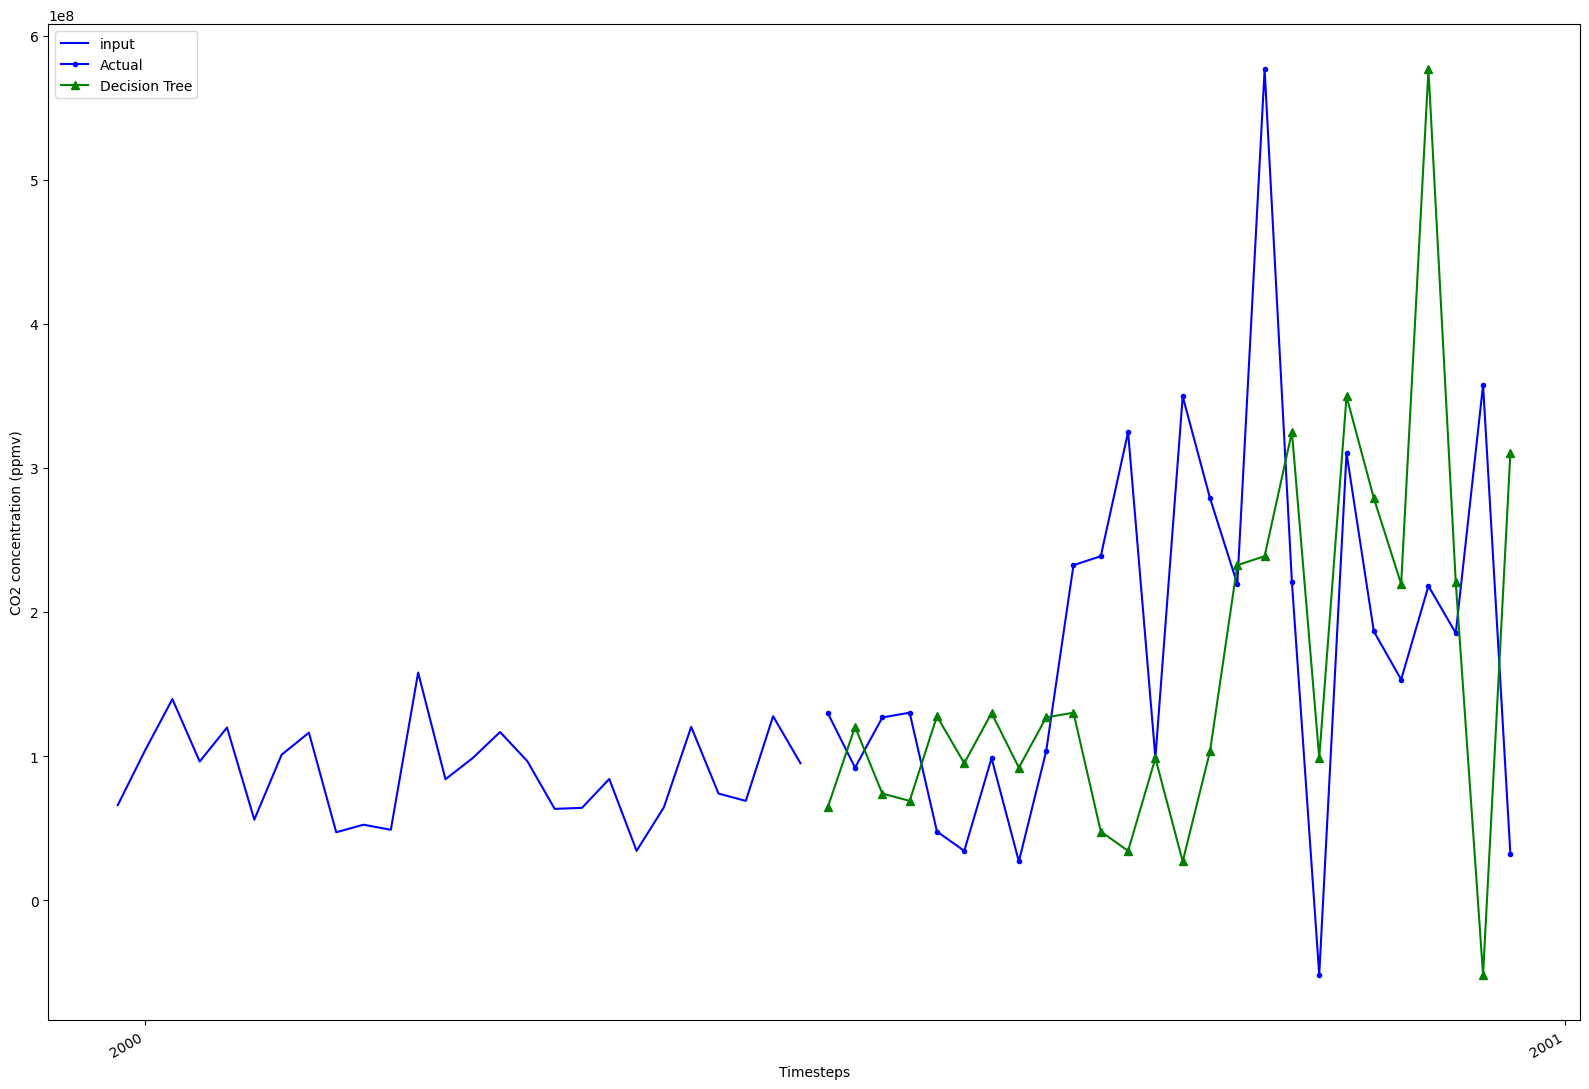

In [86]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(np.arange(0, 26, 1), X_test[1], 'b-', label='input')
ax.plot(np.arange(26, 52, 1), y_test[1], marker='.', color='blue', label='Actual')
# ax.plot(np.arange(26, 52, 1), X_test[1], marker='o', color='red', label='Baseline')
ax.plot(np.arange(26, 52, 1), dt_seq_preds[1], marker='^', color='green', label='Decision Tree')
# ax.plot(np.arange(26, 52, 1), gbr_seq_preds[1], marker='P', color='black', label='Gradient Boosting')
ax.set_xlabel('Timesteps')
ax.set_ylabel('CO2 concentration (ppmv)')
plt.xticks(np.arange(1, 104, 52), np.arange(2000, 2002, 1))
plt.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()